In [1]:
#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

# Digging deeper: approximate crossentropy with neural nets

![img](https://casd35.wikispaces.com/file/view/digging_deeper_final.jpg/359658499/503x260/digging_deeper_final.jpg)

In this section we will train a neural network policy for continuous state space game

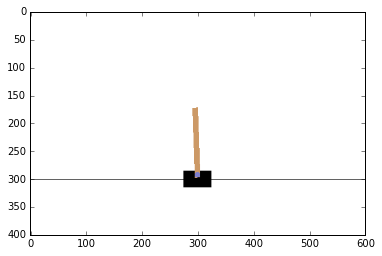

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0").env  #if you see "<classname> has no attribute .env", remove .env or update gym
env.reset()
n_actions = env.action_space.n

plt.imshow(env.render("rgb_array"))


In [51]:
print(n_actions)
print(env.action_space)
print(list(range(n_actions)))

2
Discrete(2)
[0, 1]


In [49]:
#create agent
from sklearn.neural_network import MLPClassifier
# ... 2 layers with 20 neurons each ... then a soft
agent = MLPClassifier(hidden_layer_sizes=(20,20),
                      activation='tanh',
                      warm_start=True, #keep progress between .fit(...) calls
                      max_iter=1 #make only 1 iteration on each .fit(...)
                     )
#initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()]*n_actions, list(range(n_actions)));


/home/philippew/anaconda3/envs/pythonx/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


In [50]:
print(agent)
print(agent.classes_)
print(agent.n_layers_)
print(agent.n_outputs_)

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=True)
[0 1]
4
1


In [25]:
pipo = [0.1, 0.9]
for i in range(10):
    print(np.random.choice(2,1, p=pipo))

[0]
[0]
[1]
[1]
[1]
[0]
[1]
[1]
[1]
[1]


In [52]:
def generate_session(t_max=1000):
    
    states,actions = [],[]
    total_reward = 0
    
    s = env.reset()
    print(s)
    
    for t in range(t_max):
        
        # a vector of action probabilities in current state
        probs = agent.predict_proba([s])[0] 
        
        #a = <sample action with such probabilities>
        # e.g. probs = [0.1 0.9]
        a = np.random.choice(n_actions, 1, p=probs)[0]
        
        new_s, r, done, info = env.step(a)
        
        #record sessions like you did before
        states.append(s)
        actions.append(a)
        total_reward += r
        
        s = new_s
        if done: break
    return states, actions, total_reward
        

In [53]:
generate_session()

[-0.00637261  0.03352173 -0.01885893  0.03078064]


([array([-0.00637261,  0.03352173, -0.01885893,  0.03078064]),
  array([-0.00570217, -0.16132477, -0.01824332,  0.31745422]),
  array([-0.00892867, -0.35618219, -0.01189423,  0.60432848]),
  array([-1.60523105e-02, -5.51135800e-01,  1.92336897e-04,  8.93241383e-01]),
  array([-0.02707503, -0.74626036,  0.01805716,  1.18598476]),
  array([-0.04200023, -0.94161178,  0.04177686,  1.48427264]),
  array([-0.06083247, -0.74702335,  0.07146231,  1.20492349]),
  array([-0.07577294, -0.94299245,  0.09556078,  1.51911891]),
  array([-0.09463279, -0.74914696,  0.12594316,  1.25772942]),
  array([-0.10961572, -0.55584149,  0.15109775,  1.00699728]),
  array([-0.12073255, -0.75262242,  0.17123769,  1.34305952]),
  array([-0.135785  , -0.56001789,  0.19809889,  1.1084763 ])],
 [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1],
 12.0)

### CEM steps
Deep CEM uses exactly the same strategy as the regular CEM, so you can copy your function code from previous notebook.

The only difference is that now each observation is not a number but a float32 vector.

In [54]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i][t]
    
    :returns: elite_states,elite_actions, both 1D lists of states and respective actions from elite sessions
    
    Please return elite states and actions in their original order 
    [i.e. sorted by session number and timestep within session]
    
    If you're confused, see examples below. Please don't assume that states are integers (they'll get different later).
    """
    
    #reward_threshold = <Compute minimum reward for elite sessions. Hint: use np.percentile>
    reward_threshold = np.percentile(rewards_batch, percentile)
    
    
    #elite_states  = <your code here>
    #elite_actions = <your code here>
    
    elite_states, elite_actions = [], []
    for i in range(len(rewards_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])
    
    return elite_states, elite_actions
    

# Training loop
Generate sessions, select N best and fit to those.

In [55]:
from IPython.display import clear_output

def show_progress(batch_rewards, log, percentile, reward_range=[-990,+10]):
    """
    A convenience function that displays training progress. 
    No cool math here, just charts.
    """
    
    mean_reward, threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
    log.append([mean_reward, threshold])

    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f"%(mean_reward, threshold))
    plt.figure(figsize=[8,4])
    plt.subplot(1,2,1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()
    
    plt.subplot(1,2,2)
    plt.hist(batch_rewards, range=reward_range);
    plt.vlines([np.percentile(batch_rewards, percentile)], [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()


mean reward = 1000.000, threshold=1000.000


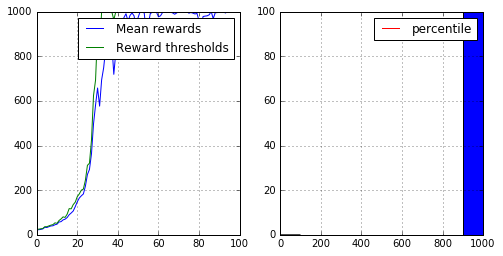

You Win! You may stop training now via KeyboardInterrupt.


In [56]:
n_sessions = 100
percentile = 70
log = []

for i in range(100):
    #generate new sessions
    #sessions = [<generate a list of n_sessions new sessions>]
    %time sessions = [generate_session() for _ in range(n_sessions)]

    batch_states, batch_actions, batch_rewards = map(np.array, zip(*sessions))

    #elite_states, elite_actions = <select elite actions just like before>
    elite_states, elite_actions = select_elites(batch_states, batch_actions, batch_rewards, percentile)
    
    #<fit agent to predict elite_actions(y) from elite_states(X)>
    agent.fit(elite_states, elite_actions)

    show_progress(batch_rewards, log, percentile, reward_range=[0,np.max(batch_rewards)])
    
    if np.mean(batch_rewards)> 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")

# Results

In [57]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True)
sessions = [generate_session() for _ in range(100)]
env.close()

[-0.00072561 -0.02824236  0.00648493 -0.03225094]
[ 0.032745   -0.00564879  0.03877696  0.04600149]
[-0.03875209  0.01887916  0.04184182  0.03163202]
[-0.03573227  0.0424953  -0.04149707 -0.03002715]
[ 0.04901819 -0.01257192 -0.01822745  0.03633966]
[ 0.02294445 -0.04093576  0.03805357 -0.03338951]
[ 0.01795097  0.04444157  0.03020428 -0.00176301]
[-0.03945019 -0.04178715  0.02017903 -0.02255365]
[ 0.03766029 -0.03050463  0.03620028  0.00030109]
[-0.02538272  0.03370218 -0.02353425 -0.01131476]
[ 0.04183239  0.02562027  0.01926802 -0.02388091]
[ 0.03972758 -0.03202848  0.00284345 -0.02927311]
[-0.01019098 -0.01381318  0.03876752  0.00482773]
[-0.00930772  0.04048226  0.0290342  -0.00814767]
[ 0.02708735  0.04723443 -0.00498721 -0.04809132]
[ 0.04302783  0.04361068  0.029496   -0.01110754]
[-0.00527105 -0.04257691 -0.04331983  0.02593549]
[ 0.04290064 -0.02142701  0.02241834  0.00447335]
[-0.03160143  0.04621711  0.01028276  0.04450285]
[-0.00523011  0.03011488  0.03903682 -0.0496638 ]


In [58]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

### Now what?

By this moment you should have got enough score on [CartPole-v0](https://gym.openai.com/envs/CartPole-v0) to consider it solved (see the link). It's time to upload the result and get to something harder.

_if you have any trouble with CartPole-v0 and feel stuck, take a look at the forums_

* Pick one of environments: MountainCar-v0 or LunarLander-v2.
  * For MountainCar, get average reward of __at least -150__
  * For LunarLander, get average reward of __at least +50__

See the tips section below, it's kinda important.
__Note:__ If your agent is below the target score, you'll still get most of the points depending on the result, so don't be afraid to submit it.
  
  
* Bonus quest: Devise a way to speed up training at least 2x against the default version
  * Obvious improvement: use [joblib](https://www.google.com/search?client=ubuntu&channel=fs&q=joblib&ie=utf-8&oe=utf-8)
  * Try re-using samples from 3-5 last iterations when computing threshold and training
  * Experiment with amount of training iterations and learning rate of the neural network (see params)
  
  
### Tips & tricks
* Gym page: [mountaincar](https://gym.openai.com/envs/MountainCar-v0), [lunarlander](https://gym.openai.com/envs/LunarLander-v2)
* Sessions for MountainCar may last for 10k+ ticks. Make sure ```t_max``` param is at least 10k.
 * Also it may be a good idea to cut rewards via ">" and not ">=". If 90% of your sessions get reward of -10k and 20% are better, than if you use percentile 20% as threshold, R >= threshold __fails cut off bad sessions__ whule R > threshold works alright.
* _issue with gym_: Some versions of gym limit game time by 200 ticks. This will prevent cem training in most cases. Make sure your agent is able to play for the specified __t_max__, and if it isn't, try `env = gym.make("MountainCar-v0").env` or otherwise get rid of TimeLimit wrapper.
* If you use old _swig_ lib for LunarLander-v2, you may get an error. See this [issue](https://github.com/openai/gym/issues/100) for solution.
* If it won't train it's a good idea to plot reward distribution and record sessions: they may give you some clue. If they don't, call course staff :)
* 20-neuron network is probably not enough, feel free to experiment.
* __Please upload the results to openai gym and send links to all submissions in the e-mail__

### Submit to Coursera

In [60]:
from submit import submit_mountain_car
submit_mountain_car(generate_session, 'philippe.weingertner@laposte.net', 'LyU6PC3y7OPUfQVk')

[ 0.01277326 -0.03401362  0.03355137  0.00942899]
[-0.01327362 -0.01770495  0.01503239 -0.04762709]
[-0.04241853  0.02131781 -0.0483144  -0.01985989]
[ 0.04886252  0.00440762 -0.03846271  0.04953716]
[-0.04656932 -0.02051124 -0.03961263  0.02947573]
[ 0.03157044  0.03929644 -0.01495678 -0.00066273]
[-0.04371891  0.03549329 -0.04377472  0.00235372]
[ 0.02921524  0.03143099 -0.02645831  0.00315508]
[ 0.00192783 -0.01995454  0.01077009 -0.0407692 ]
[ 0.04395316 -0.03696134  0.02114799 -0.04676455]
[ 0.01812504 -0.02737276 -0.00751714 -0.01533037]
[-4.66328916e-05 -2.86803300e-02 -2.60217383e-02  2.22458963e-02]
[ 0.04665885 -0.0225124   0.02203612 -0.014811  ]
[ 0.03569423 -0.02084557 -0.00517801 -0.01611171]
[0.02956874 0.04759774 0.01834713 0.0495384 ]
[-0.03097394  0.03713817 -0.03980423 -0.01776627]
[-0.00034232  0.02602668 -0.01086535 -0.02018026]
[0.0256484  0.02503599 0.03733929 0.04324719]
[-0.01341641 -0.01830288  0.01798721  0.03256644]
[ 0.01149282  0.01501232 -0.01253456 -0.00